In [7]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from app.models.rcnn import RCNN
from app.models.yolo import YOLO
import torch

# Replace 'PATH' with the actual path to your image file
#image_path = '/vol/bitbucket/cdr23/dataset_final/images/2426e558-1008368_XRAY_1.jpg'
image_path = '/vol/bitbucket/cdr23/dataset_final/images/cda4dad3-0983279_XRAY_1.jpg'
#image_path = '/vol/bitbucket/cdr23/dataset_final/images/fb8931da-0996673_XRAY_01.jpg'
#image_path = '/vol/bitbucket/cdr23/dataset_final/images/013f7dd6-1039162_XRAY_1.jpg'
#image_path = '/vol/bitbucket/cdr23/dataset_final/images/7fb0e7ec-1078893_XRAY_1.jpg'
#image_path = '/vol/bitbucket/cdr23/dataset_final/images/4dc2605d-990903_XRAY_1.jpg'
#image_path = '/vol/bitbucket/cdr23/tricky_seeds/0990006_XRAY_1.jpg'
image = Image.open(image_path)
#image = image.convert('L')
numpy_image = np.array(image)

rcnn = RCNN()
#yolo = YOLO("/vol/bitbucket/ajm223/SWE_GP/runs/segment/train17/weights/best.pt")
#rcnn.hyper_params['post-process'] = False

def show_rcnn_configs(rcnn):
    print("Training Configs \n")
    for key, value in rcnn.training_configs.items():
        key = key + " "*(20-len(key))
        print(f"\t{key}: {value}")
    print("\n")
    print("Inference Configs \n")
    for key, value in rcnn.inference_configs.items():
        key = key + " "*(20-len(key))
        print(f"\t{key}: {value}")
    print("Hyper Params \n")
    for key, value in rcnn.hyper_params.items():
        key = key + " "*(20-len(key))
        print(f"\t{key}: {value}")

#rcnn.hyper_params['post-process'] = False
#import time
#start = time.time()
#response_rcnn = rcnn.predict(numpy_image)
#end = time.time()
#print(f"RCNN DURATION: {end-start}")
#start = time.time()
#response_yolo = yolo.predict(numpy_image)
#end = time.time()
#print(f"YOLO DURATION: {end-start}")


In [8]:
show_rcnn_configs(rcnn)

Training Configs 

	id2label            : {'3': 1, '2': 2, '0': 3, '4': 4, '1': 5}
	label2id            : {'1': 3, '2': 2, '3': 0, '4': 4, '5': 1}
	name2id             : {'Endosperm': 0, 'Infestation': 1, 'Interior': 2, 'Seed': 3, 'Void': 4}
	id2name             : {'0': 'Endosperm', '1': 'Infestation', '2': 'Interior', '3': 'Seed', '4': 'Void'}
	label2name          : {'1': 'Seed', '2': 'Interior', '3': 'Endosperm', '4': 'Void', '5': 'Infestation'}
	name2label          : {'Seed': 1, 'Interior': 2, 'Endosperm': 3, 'Void': 4, 'Infestation': 5}
	label_order         : [1, 2, 3, 4, 5]
	hyper_params        : {'train_batch_size': 5, 'val_batch_size': 5, 'step_every': 10, 'num_epochs': 10, 'learning_rate': 0.0001, 'max_detections': 200, 'binary_threshold': 0.5, 'pre-process': True, 'post-process': False, 'model_path': 'app/models/final_model_weights/rcnn.pt'}
	num_classes         : 5
	model_path          : app/models/final_model_weights/rcnn.pt
	class_order         : ['Seed', 'Interior', 'Endos

In [14]:
#pred = rcnn.model([torch.tensor(numpy_image/255).to(torch.float32).view(1, numpy_image.shape[0], numpy_image.shape[1])])
def plot_targets(numpy_image, pred, threshold, label2name):
    total = np.zeros(shape=(7, numpy_image.shape[0], numpy_image.shape[1]))
    for i in range(len(pred['labels'])):
        label = pred['labels'][i]
        total[label] += (pred['masks'][i] > threshold).to(torch.int).detach().cpu().numpy().squeeze()
    #print(pred['masks'].sum())

    for i in range(len(total)):
        if total[i].sum() == 0:
            continue
        plt.imshow(numpy_image, cmap='gray')
        alpha = np.where(total[i] == 0, 0, 1).astype(np.float64)
        plt.imshow(total[i], alpha=alpha, cmap="spring")
        plt.axis('off')
        plt.title(f"{label2name[i]}")
        plt.colorbar()
        plt.show()
#plot_targets(numpy_image, pred[0], rcnn.hyper_params['binary_threshold'])

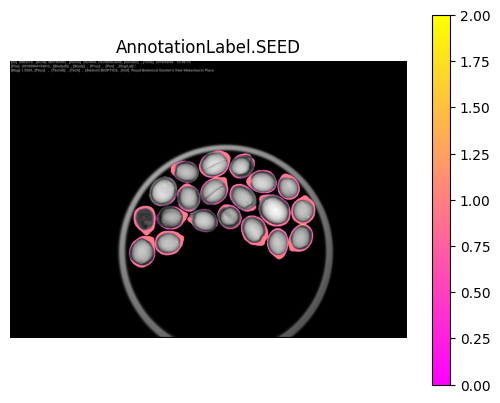

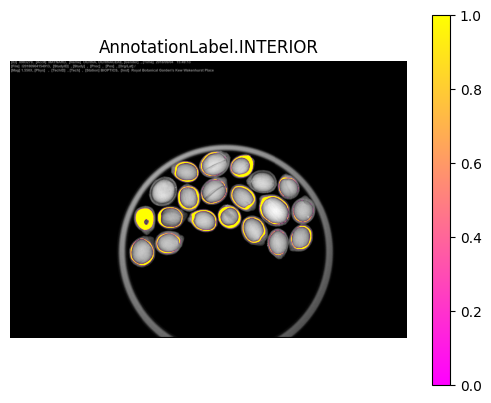

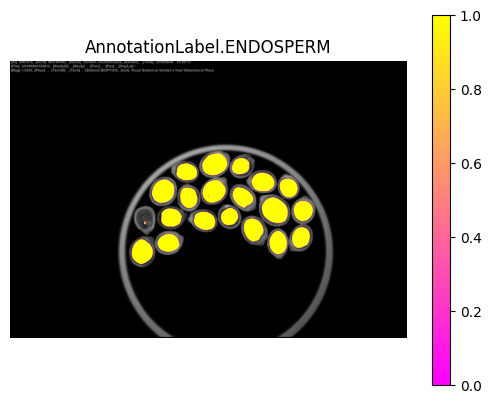

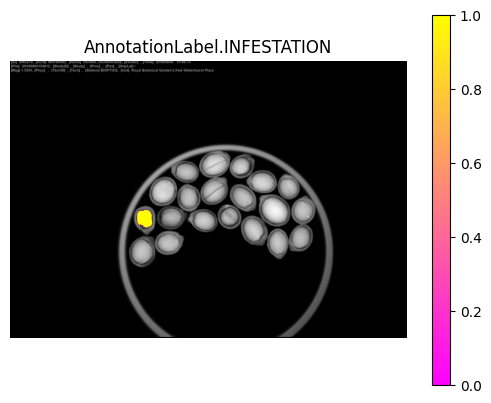

In [9]:
def plot_types(numpy_image, response):
    total = np.zeros(shape=(7, numpy_image.shape[0], numpy_image.shape[1]))
    names = dict()
    for i, annot in enumerate(response.annotations):
        if len(names) <= 7:
            names[annot.label.value] = annot.label
        label = annot.label.value
        total[label] += annot.mask/255

    for i in range(len(total)):
        if total[i].sum() == 0:
            continue
        plt.imshow(numpy_image, cmap='gray')
        alpha = np.where(total[i] == 0, 0, 1).astype(np.float64)
        plt.imshow(total[i], alpha=alpha, cmap="spring")
        plt.axis('off')
        plt.title(f"{names[i]}")
        plt.colorbar()
        plt.show()
response_rcnn = rcnn.predict(numpy_image)
plot_types(numpy_image, response_rcnn)

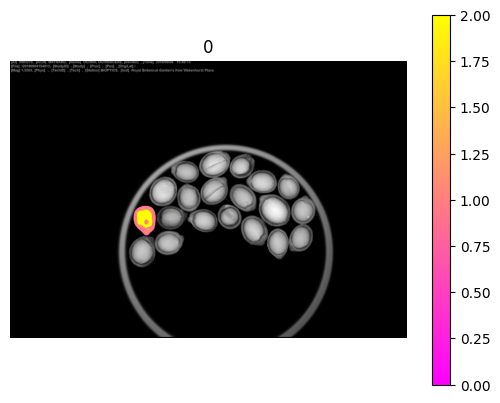

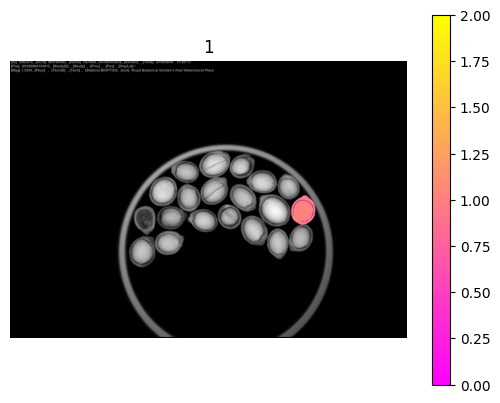

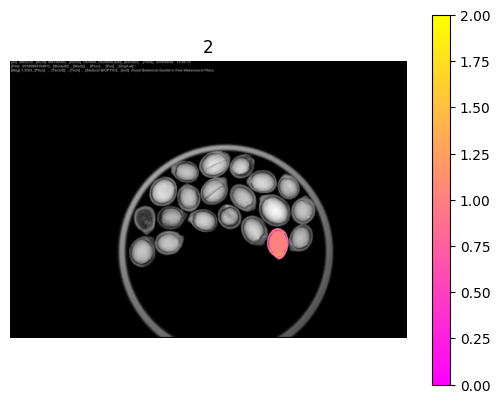

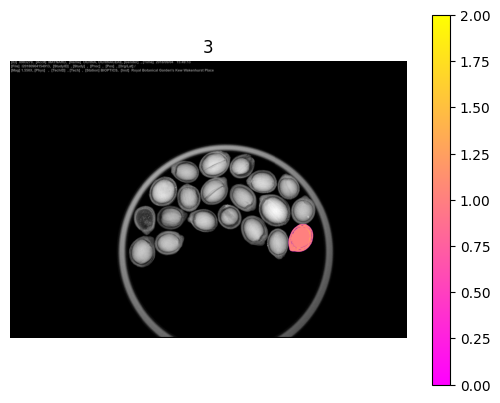

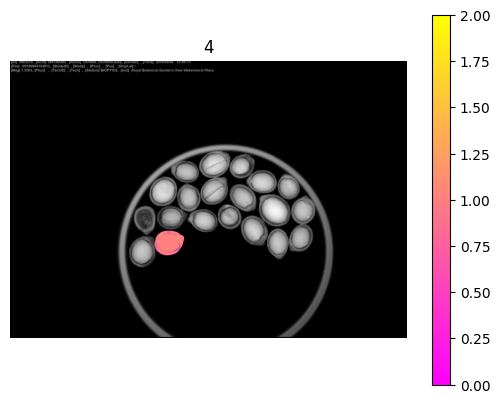

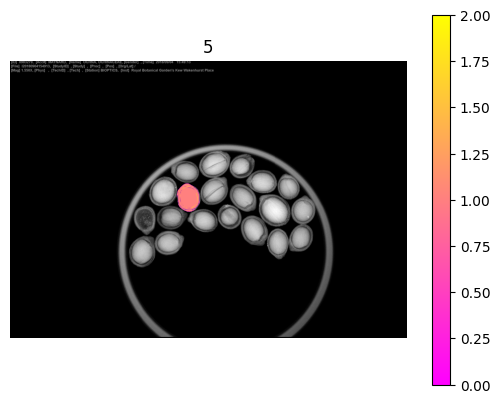

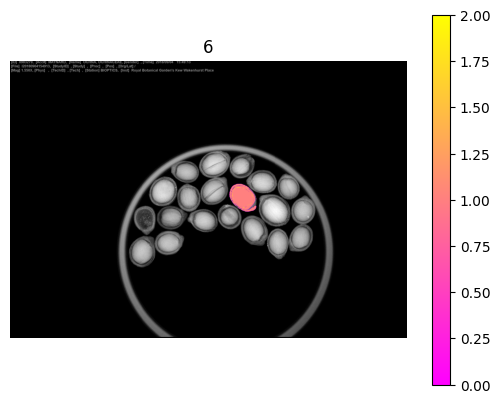

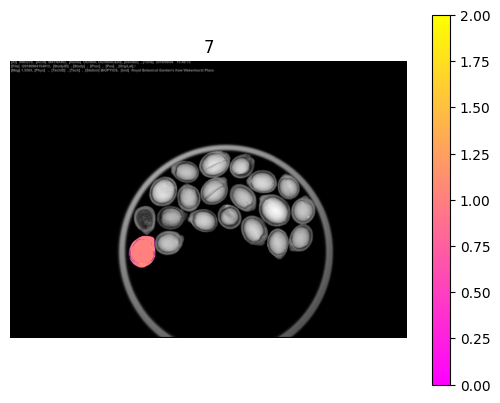

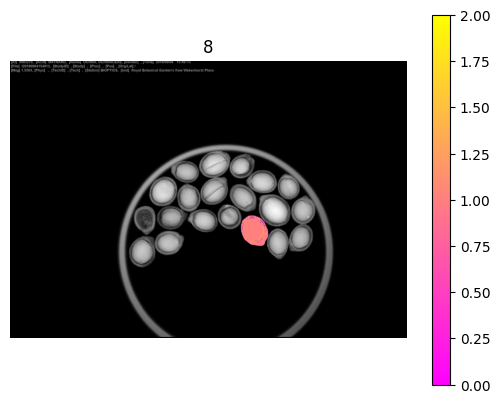

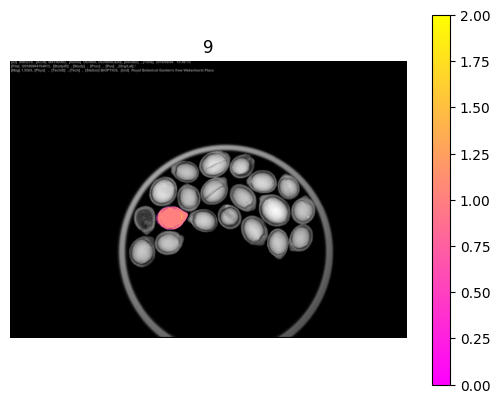

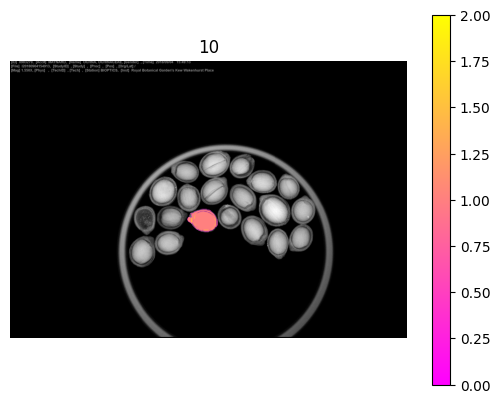

In [ ]:
def plot_seeds(numpy_image, response):
    seeds = np.unique([annot.seed_id for annot in response.annotations if annot.seed_id is not None])
    total_seeds = np.zeros(shape=(len(seeds), numpy_image.shape[0], numpy_image.shape[1]))
    total_non_seeds = np.zeros(shape=(numpy_image.shape[0], numpy_image.shape[1]))
    for i, annot in enumerate(response.annotations):
        if annot.seed_id is not None:
            total_seeds[annot.seed_id] += annot.mask/255
        else:
            total_non_seeds += annot.mask/255

    for i in seeds:
        if total_seeds[i].sum() == 0:
            print('empty')
            continue
        plt.imshow(numpy_image, cmap='gray')
        alpha = np.where(total_seeds[i] == 0, 0, 1).astype(np.float64)
        plt.imshow(total_seeds[i], alpha=alpha, cmap="spring")
        plt.axis('off')
        plt.title(f"{i}")
        plt.colorbar()
        plt.show()

    plt.imshow(numpy_image, cmap='gray')
    alpha = np.where(total_non_seeds == 0, 0, 1).astype(np.float64)
    plt.imshow(total_non_seeds, alpha=alpha, cmap="spring")
    plt.axis('off')
    plt.title(f"Nunya")
    plt.colorbar()
    plt.show()
plot_seeds(numpy_image, response_rcnn)

In [5]:
from app.models.rcnn import RCNN
from app.models.yolo import YOLO
import matplotlib.pyplot as plt
import torch
import sys
sys.path.insert(0, "~/millenium")
import numpy as np
from src.evaluation.evaluation import full_evaluation

rcnn = RCNN()
yolo = YOLO("/vol/bitbucket/ajm223/SWE_GP/runs/segment/train17/weights/best.pt")
torch.manual_seed(0)
for pp in [True, False]:
    rcnn.hyper_params['post-process'] = pp
    print(full_evaluation(
        model = rcnn,
        test_folder="/vol/bitbucket/cdr23/dataset_final/",
        test_json="/vol/bitbucket/cdr23/dataset_final/full_test.json",
        device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
        #pred_func=plot_types,
        #targ_func=plot_targets,
    ))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
0
5
10
({1: 0.1738032410556281, 2: 0.17210080906410108, 3: 0.5029476447538896, 4: -0.09999999829701015, 5: -0.29850945331984097}, 0.2477798048745502)
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
0
5
10
({1: 0.18130709692327815, 2: 0.18796472310681234, 3: 0.5194683799689467, 4: -0.09999999829701015, 5: -0.29850945331984097}, 0.2593688707460057)


In [ ]:
yolo_heldout_performance = ({1: 0.10459113375029781, 2: 0.10165540907870639, 3: 0.40569237755103543, 4: 0.0, 5: -0.13861386132027423}, 0.16727679680016908)
rcnn_heldout_performacne = ({1: 0.12231283563993532, 2: 0.14008295663039794, 3: 0.44800128449093213, 4: -0.11428571598870414, 5: -0.2999871888508399}, 0.21144987981427799)
yolo_synth_performance = ({1: 0.2228163109077806, 2: 0.06049539351952262, 3: 0.4520873196107069, 4: -0.26643067967464645, 5: -0.15603875172221}, 0.23229345466894474)
rcnn_synth_performacne = ({1: 0.13382612126602214, 2: 0.05475301331441317, 3: 0.3988144400884353, 4: -0.4733194372200064, 5: -0.4730997303147511}, 0.1905267243815442)
abel2name = {1: 'Seed', 2: 'Interior', 3: 'Endosperm', 4: 'Void', 5: 'Infestation'}